# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [2]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [3]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [4]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [5]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [6]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [7]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [8]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [10]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [11]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]], dtype=int64)

In [13]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print(u'столбец %d: %s' % (i, w))

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [14]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [15]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [16]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [17]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

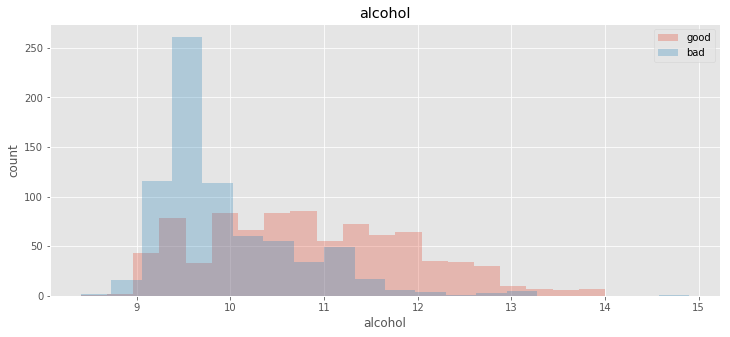

In [18]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [19]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [22]:
model = SimpleClassifier()
model.fit(X, y)

print('Оптимальный порог: %f' % model.threshold)

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [23]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [25]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print('Доля ошибок на обучающей выборке: %f' % error_rate)

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [26]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [27]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [28]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print('Доля ошибок на контрольной выборке: %f' % error_rate)

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.spatial.distance import cdist

class KMeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init

    def init_centroids(self, X):
        if self.init == "k-means":
            self.centroids = [X[np.random.choice(X.shape[0], replace=False)]]
            for i in range(1, self.k):
                cumsum = np.cumsum(cdist(X, self.centroids).min(axis=1) ** 2)
                index = (cumsum >= np.random.random() * cumsum[-1]).tolist().index(True)
                self.centroids.append(X[index])
            
            self.centroids = np.array(self.centroids)            
        else:
            self.centroids = X[np.random.choice(X.shape[0], size=self.k, replace=False)]

        
    def update_centroids(self, X):
        while True:
            prev_centroids = self.centroids.copy()
            labels = self.predict(X)
            self.centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.k)])
            
            nan_centroids = np.isnan(self.centroids.sum(axis=1))
            self.centroids[nan_centroids] = prev_centroids[nan_centroids]
            if ((prev_centroids - self.centroids) ** 2).mean() <= 1e-6:
                break
        
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.init_centroids(X)
        self.update_centroids(X)
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return cdist(X, self.centroids).argmin(axis=1)

class MiniBatchKMeans(KMeans):
    
    def __init__(self, batch_size=100, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
    
    def update_centroids(self, X):
        v = np.zeros((self.k,))
        while True:
            prev_centroids = self.centroids.copy()
            
            M = X[np.random.randint(0, X.shape[0], size=self.batch_size)]
            d = self.predict(M)
            for x, c in zip(M, d):
                v[c] += 1
                lr = 1.0 / v[c]
                self.centroids[c] = (1 - lr) * self.centroids[c] + lr * x
            
            
            nan_centroids = np.isnan(self.centroids.sum(axis=1))
            self.centroids[nan_centroids] = prev_centroids[nan_centroids]
            if ((prev_centroids - self.centroids) ** 2).mean() <= 1e-6:
                break



### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

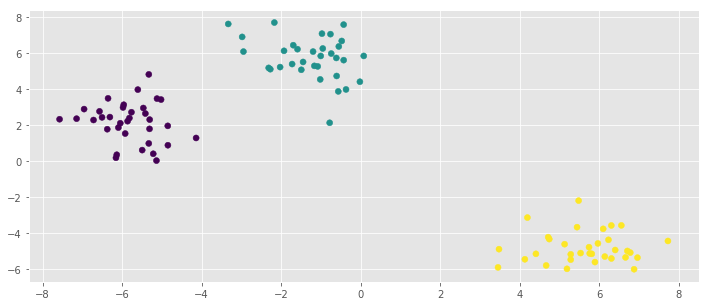

In [59]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

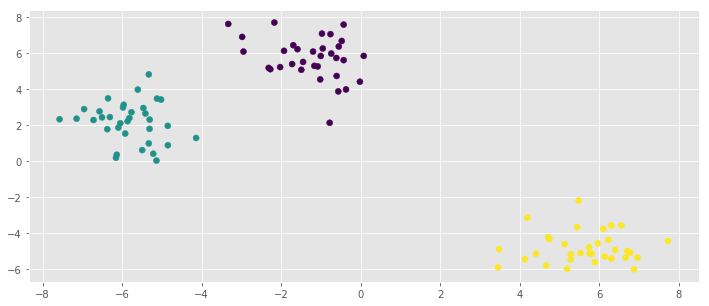

In [60]:
## Работоспособность KMeans
y_pred = KMeans(k=3, random_state=1234).fit(X).predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)

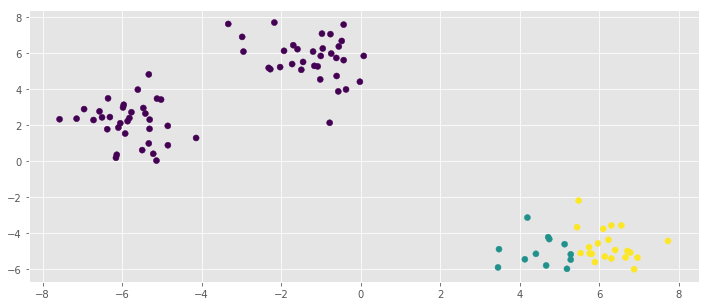

In [61]:
## Работоспособность KMeans++
y_pred = KMeans(k=3, init="k-means", random_state=1234).fit(X).predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)

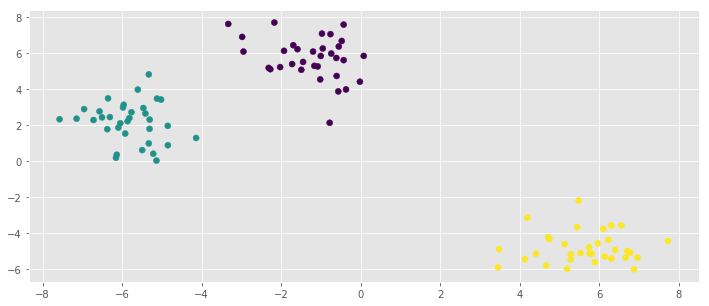

In [62]:
## Работоспособность KMeans с MiniBatchKMeans
y_pred = MiniBatchKMeans(k=3, random_state=1234).fit(X).predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)

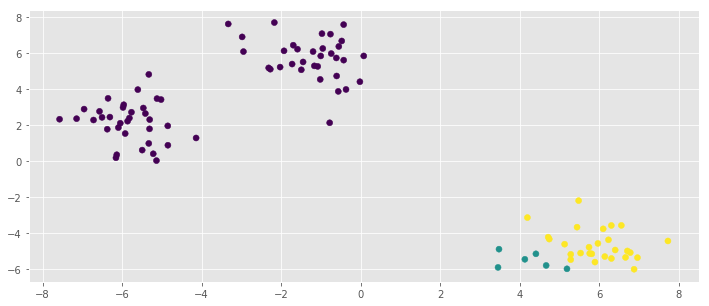

In [63]:
## Работоспособность KMeans++ с MiniBatchKMeans
y_pred = MiniBatchKMeans(k=3, init="k-means", random_state=1234).fit(X).predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)

In [70]:
import timeit

def make_x(n_samples):
    X, y = make_blobs(n_samples=n_samples, n_features=2, centers=3, cluster_std=1, 
                      center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    return X

COUNT = 10

def test_method(methods, method_names):
    x = np.logspace(1, 6, num=6).astype(int)
    for method, method_name in zip(methods, method_names):
        y = np.array([timeit.timeit("method.fit(X).predict(X)", number=COUNT, globals={"method": method, "X": make_x(i), "i": i}) for i in x])
        y /= COUNT
        plt.plot(x, y, label=method_name)
    plt.xlabel("Points to clusterize")
    plt.ylabel("Time, s")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()

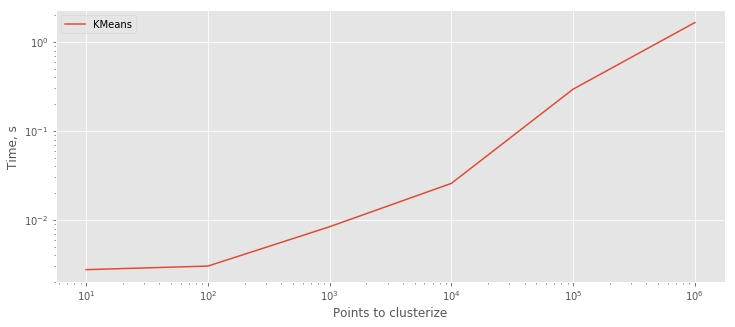

In [71]:
## Время выполнения алгоритма KMeans
test_method([KMeans(k=3)], ["KMeans"])

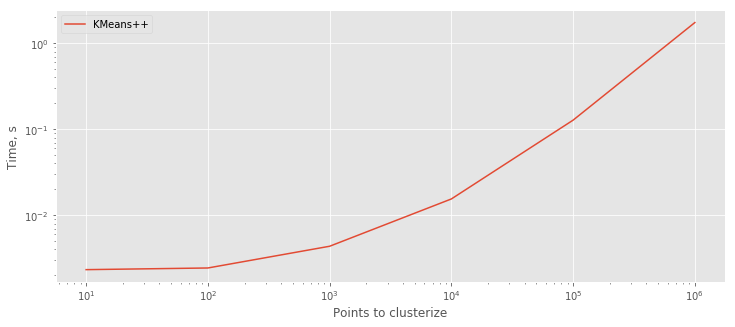

In [72]:
## Время выполнения алгоритма KMeans++
test_method([KMeans(k=3, init="k-means")], ["KMeans++"])

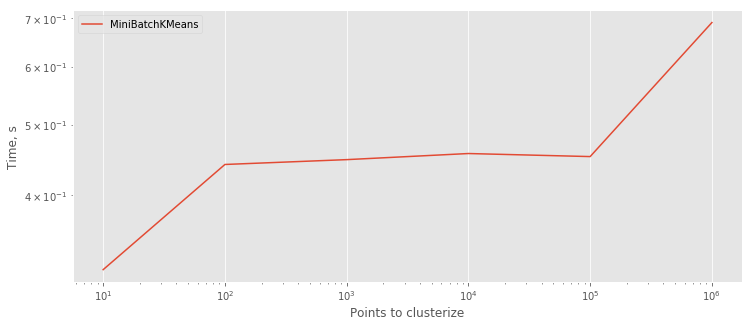

In [73]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
test_method([MiniBatchKMeans(k=3)], ["MiniBatchKMeans"])

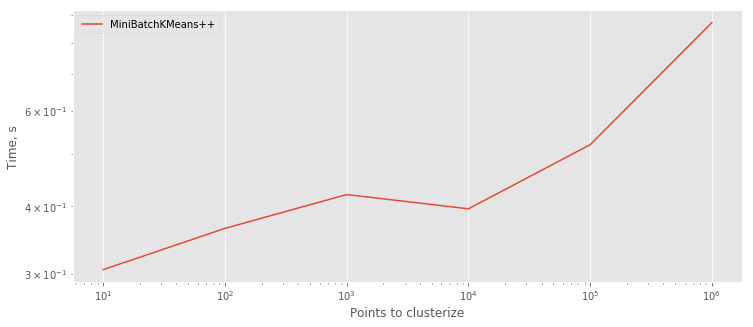

In [74]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
test_method([MiniBatchKMeans(k=3, init="k-means")], ["MiniBatchKMeans++"])

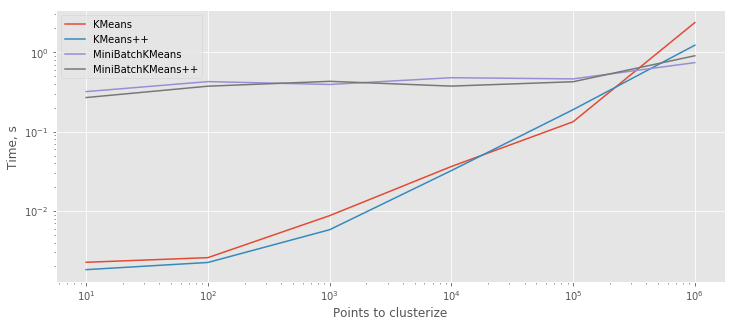

In [75]:
## Сравнение на одном графике
test_method([KMeans(k=3), KMeans(k=3, init="k-means"), MiniBatchKMeans(k=3), MiniBatchKMeans(k=3, init="k-means")], ["KMeans", "KMeans++", "MiniBatchKMeans", "MiniBatchKMeans++"])

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [15]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
_df_sns = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1)
_df_sns -= _df_sns.mean()
_df_sns /= _df_sns.std()

df_sns = df_sns.join(pd.get_dummies(df_sns["gender"], prefix='gender', prefix_sep='='))

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

,gradyear,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,...,clothes,hollister,abercrombie,die,death,drunk,drugs,gender=F,gender=M,count
label,,,,,,,,,,,,,,,,,,,,,
0,2007.604348,17.634426,30.688043,0.540217,0.497826,0.323913,0.201087,0.200000,0.279348,0.196739,...,0.705435,0.131522,0.131522,1.296739,0.533696,0.854348,1.061957,0.798913,0.144565,920
1,2007.379167,18.964213,32.416667,0.416667,0.358333,0.429167,0.070833,0.145833,0.225000,0.070833,...,0.191667,0.066667,0.070833,0.187500,0.112500,0.045833,0.054167,0.666667,0.237500,240
2,2007.357143,19.031807,35.446429,0.346939,0.255102,0.198980,0.145408,0.114796,0.183673,0.107143,...,0.165816,0.038265,0.020408,0.372449,0.288265,0.112245,0.084184,0.752551,0.178571,392
3,2007.852556,17.486570,41.740785,0.386445,0.392390,0.299643,0.155767,0.210464,0.255648,0.316290,...,0.423306,1.508918,1.171225,0.219976,0.152200,0.104637,0.076100,0.838288,0.083234,841
4,2007.685687,17.764591,32.569187,1.204470,1.464574,1.367095,0.155017,0.149786,0.166429,0.155968,...,0.118878,0.038516,0.016167,0.140751,0.086543,0.065145,0.031859,0.560152,0.389444,2103


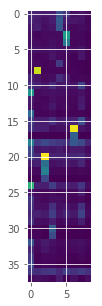

In [26]:
## KMeans
df_sns["label"] = KMeans(k=9, random_state=123).fit(_df_sns.values).predict(_df_sns.values)
result = df_sns.groupby("label").agg(np.mean)
result["count"] = df_sns.groupby("label").size()
plt.imshow(result.transpose().values[3: -1])
result.head()

In [6]:
## KMeans++
df_sns["label"] = KMeans(k=9, init="k-means").fit(_df_sns.values).predict(_df_sns.values)
result = df_sns.groupby("label").agg(np.mean)
result["count"] = df_sns.groupby("label").size()
result.head()

,gradyear,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,...,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,count
label,,,,,,,,,,,,,,,,,,,,,
0,2007.436595,18.153937,27.344228,0.120022,0.121933,0.151247,0.061293,0.062098,0.079395,0.049527,...,0.120676,0.175734,0.053650,0.015537,0.009403,0.112580,0.073663,0.037711,0.015286,19888
1,2006.500000,18.131500,46.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.500000,0.000000,0.000000,3.000000,3.500000,3.000000,0.000000,2
2,2007.736457,17.339955,35.512468,1.450989,1.156492,0.631986,1.095443,0.847807,0.181857,0.162511,...,0.259243,0.370163,0.159071,0.036113,0.021496,0.134566,0.101032,0.044712,0.025365,2326
3,2007.356041,18.112433,32.726221,0.168380,0.268638,0.155527,0.111825,0.089974,0.156812,0.050129,...,0.178663,0.291774,0.142674,0.011568,0.011568,0.172237,0.124679,0.052699,0.034704,778
4,2007.844444,17.485769,41.633918,0.378947,0.394152,0.314620,0.171930,0.246784,0.254971,0.306433,...,0.672515,0.920468,0.409357,1.498246,1.149708,0.216374,0.156725,0.101754,0.065497,855


In [8]:
## KMeans с MiniBatchKMeans
df_sns["label"] = MiniBatchKMeans(k=9).fit(_df_sns.values).predict(_df_sns.values)
result = df_sns.groupby("label").agg(np.mean)
result["count"] = df_sns.groupby("label").size()
result.head()

,gradyear,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,...,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,count
label,,,,,,,,,,,,,,,,,,,,,
0,2007.365964,18.695636,36.228916,0.268072,0.298193,0.159639,0.117470,0.103916,0.165663,0.106928,...,0.222892,0.388554,0.170181,0.039157,0.027108,0.350904,0.278614,0.093373,0.069277,664
1,2007.737113,17.293640,34.339175,0.495876,0.781443,0.245361,0.167010,0.119588,0.195876,0.224742,...,0.380412,0.358763,0.188660,0.074227,0.054639,0.158763,0.100000,0.072165,0.036082,970
2,2007.643878,17.593483,37.575036,0.202239,0.330157,0.133873,0.090519,0.110767,0.315150,0.358742,...,0.775369,1.140305,0.398047,0.306813,0.225107,0.195093,0.140305,0.093140,0.034302,4198
3,2007.611262,17.655232,29.875568,0.493188,0.515895,0.264305,0.189827,0.178928,0.267030,0.209809,...,0.674841,0.563124,0.770209,0.226158,0.187103,1.175295,0.521344,0.789282,0.952770,1101
4,2007.769118,17.709118,35.558824,0.389706,0.400000,4.954412,0.117647,0.154412,0.197059,0.092647,...,0.283824,0.513235,0.126471,0.098529,0.055882,0.182353,0.100000,0.069118,0.045588,680


In [7]:
## KMeans++ с MiniBatchKMeans
df_sns["label"] = MiniBatchKMeans(k=9, init="k-means").fit(_df_sns.values).predict(_df_sns.values)
result = df_sns.groupby("label").agg(np.mean)
result["count"] = df_sns.groupby("label").size()
result.head()

,gradyear,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,...,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,count
label,,,,,,,,,,,,,,,,,,,,,
0,2007.210821,17.906571,35.117537,0.373134,0.382463,0.251866,0.238806,0.194030,0.154851,0.154851,...,0.546642,0.824627,0.292910,0.085821,0.061567,0.208955,0.130597,0.108209,0.057836,536
1,2007.666667,17.429816,35.085185,0.382716,0.397531,0.260494,0.146914,0.151852,0.156790,0.141975,...,0.420988,0.586420,0.255556,0.064198,0.071605,0.322222,0.174074,0.109877,0.049383,810
2,2007.607143,18.090264,38.234962,0.446429,0.361842,0.325188,0.270677,0.176692,0.171053,0.115602,...,0.384398,0.544173,0.208647,0.037594,0.019737,0.243421,0.169173,0.079887,0.043233,1064
3,2007.444504,18.137825,27.831963,0.179940,0.175718,0.175448,0.095764,0.083098,0.088038,0.050622,...,0.131788,0.197637,0.058123,0.012577,0.007232,0.125185,0.077303,0.049859,0.022414,22263
4,2007.395225,18.292761,32.962865,0.175066,0.352785,0.127321,0.116711,0.090186,0.177719,0.063660,...,0.214854,0.360743,0.148541,0.013263,0.015915,0.190981,0.145889,0.061008,0.050398,377


## Вывод

В данных присутствует 9 кластеров:

- Рокеры
- Теннисисты
- Верующие
- Черлидеры, любящие пошопиться
- Спортсмены (баскетбол, футбол)
- Девочки-спортсмены (софтбол, волейбол)
- Националисты
- Танцоры
- Скрытные люди